# COVID-19 Tweet Sentiment Prediction

Given tweets about the COVID-19 pandemic, let's try to predict the sentiment of a given tweet.

We will use a Tensorflow RNN to make our prediction.

### Getting Started

In [1]:
# importing libs
import numpy as np
import pandas as pd
import plotly.express as px

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# reading the data
train_df = pd.read_csv('./data/train.csv', encoding='latin-1')
test_df = pd.read_csv('./data/test.csv', encoding='latin-1;')

### Getting to know more about the data

In [3]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
print(train_df.columns, '\n')
print(test_df.columns)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object') 

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8055 entries, 0 to 8054
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       8055 non-null   int64 
 1   ScreenName     8055 non-null   int64 
 2   Location       6469 non-null   object
 3   TweetAt        8055 non-null   object
 4   OriginalTweet  8055 non-null   object
 5   Sentiment      8054 non-null   object
dtypes: int64(2), object(4)
memory usage: 377.7+ KB


In [7]:
train_df.describe()

,UserName,ScreenName
count,8055.000000,8055.000000
mean,7826.000000,52778.000000
std,2325.422542,2325.422542
min,3799.000000,48751.000000
25%,5812.500000,50764.500000
50%,7826.000000,52778.000000
75%,9839.500000,54791.500000
max,11853.000000,56805.000000


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [9]:
test_df.describe()

,UserName,ScreenName
count,3798.000000,3798.000000
mean,1899.500000,46851.500000
std,1096.532489,1096.532489
min,1.000000,44953.000000
25%,950.250000,45902.250000
50%,1899.500000,46851.500000
75%,2848.750000,47800.750000
max,3798.000000,48750.000000


In [10]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         1586
TweetAt             0
OriginalTweet       0
Sentiment           1
dtype: int64

In [11]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [12]:
train_df['Sentiment'].value_counts()

Positive              2158
Negative              2024
Neutral               1427
Extremely Negative    1233
Extremely Positive    1212
Name: Sentiment, dtype: int64

In [13]:
test_df['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

### Data Preprocessing

In [14]:
train_inputs = train_df['OriginalTweet'].copy()
test_inputs = test_df['OriginalTweet'].copy()

train_labels = train_df['Sentiment'].copy()
test_labels = test_df['Sentiment'].copy()

In [15]:
# encoding sentiment to numbers
sentiment_encoding = {'Extremely Negative': 0, 
        'Negative': 0, 
        'Neutral': 1, 
        'Positive': 2, 
        'Extremely Positive': 2}

In [16]:
train_labels = train_labels.replace(sentiment_encoding)
test_labels = test_labels.replace(sentiment_encoding)

In [17]:
train_labels

0       1.0
1       2.0
2       2.0
3       2.0
4       0.0
       ... 
8050    0.0
8051    0.0
8052    2.0
8053    0.0
8054    NaN
Name: Sentiment, Length: 8055, dtype: float64

In [18]:
stop_words = stopwords.words('english')

In [19]:
def process_tweet(tweet):
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)

    # remove html tags
    tweet = re.sub(r'<.*?>', ' ', tweet)

    # remove digits
    tweet = re.sub(r'\d+', ' ', tweet)

    # remove hashtags
    tweet = re.sub(r'#\W+', ' ', tweet)

    # remove mentions
    tweet = re.sub(r'@]W+', ' ', tweet)

    # removing stopwords
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])

    return tweet

In [20]:
train_inputs = train_inputs.apply(process_tweet)
test_inputs = test_inputs.apply(process_tweet)

In [21]:
train_inputs

0                         @MeNyrbie @Phil_Gahan @Chrisitv
1       advice Talk neighbours family exchange phone n...
2       Coronavirus Australia: Woolworths give elderly...
3       My food stock one empty... PLEASE, panic, THER...
4       Me, ready go supermarket #COVID outbreak. Not ...
                              ...                        
8050    Hit grocery store early attempt find one elusi...
8051    Home Affairs Minister Peter Dutton says joint ...
8052    Well I NEVER get #weightloss side effect anyth...
8053    @Nigel @balmaingourmet I agree wholeheartedly ...
8054    @eBay going anything this? Absolutely disgusti...
Name: OriginalTweet, Length: 8055, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



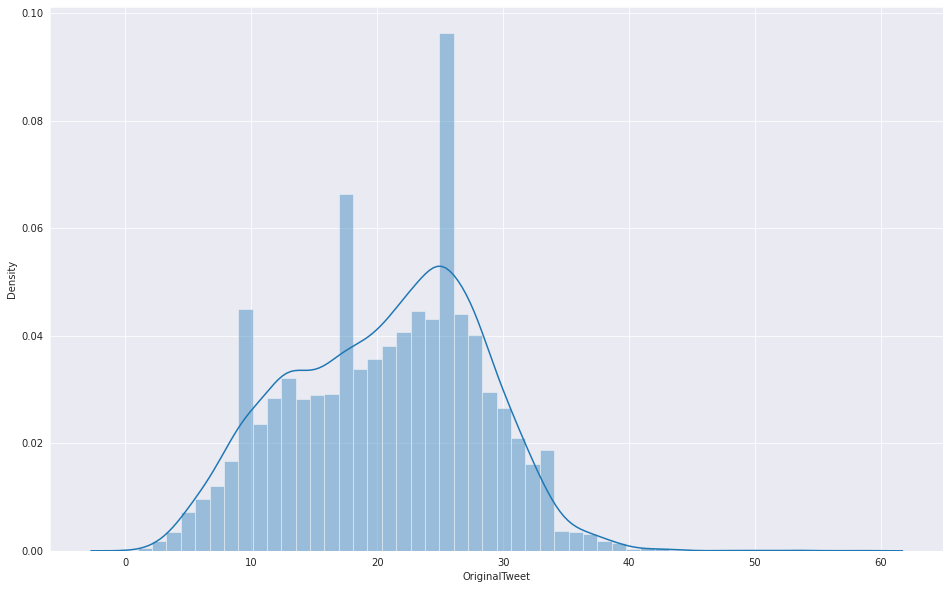

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

seqlen = train_inputs.apply(lambda x: len(x.split()))

# visualizing
sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))
sns.distplot(seqlen)

In [23]:
# max_seq_len = np.max(train_inputs.apply(lambda tweet: len(tweet.split())))
# max_seq_len

In [24]:
SEQ_LEN = 100
VOCAB_LEN = 20000

In [25]:
tokenizer = Tokenizer(num_words=VOCAB_LEN)
tokenizer.fit_on_texts(train_inputs)

In [26]:
# word_index = tokenizer.word_index
# vocab_len = len(tokenizer.word_index) + 1
# vocab_len

In [27]:
train_inputs = tokenizer.texts_to_sequences(train_inputs)
test_inputs = tokenizer.texts_to_sequences(test_inputs)

In [28]:
PAD = 'post'
TRUNC = 'post'
EMBED_DIM = 128
BATCH_SIZE = 32
EPOCHS = 2

In [29]:
train_inputs = pad_sequences(train_inputs, maxlen=SEQ_LEN, padding=PAD, truncating=TRUNC)
test_inputs = pad_sequences(test_inputs, maxlen=SEQ_LEN, padding=PAD, truncating=TRUNC)

### Model Building

In [30]:
train_inputs.shape

(8055, 100)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=VOCAB_LEN,
        output_dim=EMBED_DIM,
        input_length=SEQ_LEN),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            256,
            return_sequences=True)
    ),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 512)          592896    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [32]:
history = model.fit(
        train_inputs,
        train_labels,
        validation_split=0.12,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
        )

Epoch 1/2
222/222 [==============================] - 18s 60ms/step - loss: 0.8600 - accuracy: 0.5899 - val_loss: nan - val_accuracy: 0.7270
Epoch 2/2
222/222 [==============================] - 12s 56ms/step - loss: 0.4527 - accuracy: 0.8397 - val_loss: nan - val_accuracy: 0.7446


### Results

In [33]:
model.evaluate(test_inputs, test_labels)

119/119 [==============================] - 3s 23ms/step - loss: 0.6521 - accuracy: 0.7467


[0.6521453857421875, 0.7467088103294373]

In [36]:
# Predict test
gru_pred = np.round(model.predict(test_inputs))
gru_pred

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [38]:
gru_pred_rounded =np.argmax(gru_pred, axis=1)
gru_pred_rounded[1]

2

In [39]:
# Precision , Recall , F1-score
cr = classification_report(test_labels,gru_pred_rounded)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1633
           1       0.73      0.57      0.64       619
           2       0.76      0.80      0.78      1546

    accuracy                           0.75      3798
   macro avg       0.75      0.71      0.73      3798
weighted avg       0.75      0.75      0.75      3798



In [40]:
# ## save
# model.save('sent_anlysis_covid_tweet.h5')